## Ovrlpy

Analyze the VSI across the tissue section using `ovrlpy` (13/05/2025 updated)  

**Tool**: `ovrlpy`  
**Data Link**: [Supplemental Data for: Segmentation-free inference of cell types from in situ transcriptomics data](https://zenodo.org/records/3478502)  
- merfish_barcodes_example.csv: mRNA spot locations


In this notebook, we will use `ovrlpy` to investigate the [mouse hypothalamus data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.8t8s248) (Moffitt et al., 2018).  
We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.  


### packages

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ovrlpy

### Data

#### load transcript data and define settings and input files

merfish_barcodes_example.csv contains 3739360 rows and 13 columns:  
- Gene_name: Gene  
- Cell_name:   
- Animal_ID: 1  
- Bregma: -0.24  
- Animal_sex: Female  
- Behavior: Naive  
- Centroid_X: the x coordinate  
- Centroid_Y: the y coordinate  
- Centroid_Z: the z coordinate  
- Total_brightness:  
- Area:  
- Error_bit:  
- Error_direction:  

In [2]:
data_folder_path = Path(
    "../data/mouse_hypothalamus/MERFISH/"
)

result_folder = Path("../data/results/VSI")
result_folder.mkdir(exist_ok=True, parents=True)

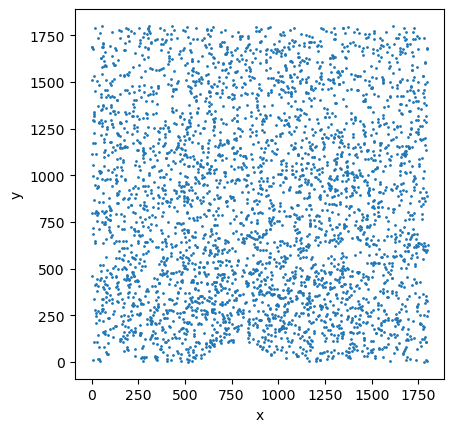

,gene,Cell_name,x,y,z,Total_brightness,Area,Error_bit,Error_direction
0,Krt90,NaN,72.880,166.913,0.0,283.25800,7,0,0
1,Krt90,NaN,75.424,0.411,0.0,36.64278,4,0,0
2,Krt90,96121573-136d-4fbe-8b2f-62f29a4703ed,150.051,170.394,0.0,30.92323,4,0,0
3,Krt90,NaN,150.431,101.975,0.0,28.73519,4,0,0
4,Krt90,NaN,161.335,161.646,0.0,425.50650,6,0,0


In [3]:
columns = [
    "Centroid_X",
    "Centroid_Y",
    "Centroid_Z",
    "Gene_name",
    "Cell_name",
    "Total_brightness",
    "Area",
    "Error_bit",
    "Error_direction",
]

coordinate_df = pd.read_csv(
    data_folder_path / "merfish_barcodes_example.csv", usecols=columns
).rename(
    columns={
        "Centroid_X": "x",
        "Centroid_Y": "y",
        "Centroid_Z": "z",
        "Gene_name": "gene",
    }
)
# coordinate_df["gene"] = coordinate_df["gene"].str.decode("utf-8")


# remove dummy molecules
coordinate_df = coordinate_df.loc[
    ~coordinate_df["gene"].str.contains("Blank|NegControl"),
]

coordinate_df["gene"] = coordinate_df["gene"].astype("category")

# shift the coordinates to avoid the negative values
coordinate_df['x'] = coordinate_df['x'] - coordinate_df['x'].min()
coordinate_df['y'] = coordinate_df['y'] - coordinate_df['y'].min()

coordinate_df[::1000].plot.scatter(x="x", y="y", s=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# make a copy to avoid SettingWithCopyWarning
coordinate_df = coordinate_df.copy()
coordinate_df.head()

### Run the ovrlpy pipeline
fit an ovrlpy model to the data and create a signal integrity map

In [4]:
# define ovrlpy analysis parameters
n_components = 15

In [5]:
# fit the ovrlpy model to the data
dataset = ovrlpy.Ovrlp(
    coordinate_df,
    n_components=n_components,
    n_workers=8,  # number of threads to use for processing
)

dataset.analyse()

Running vertical adjustment
Creating gene expression embeddings for visualization
determining pseudocells
found 3915 pseudocells
sampling expression:


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]
d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Modeling 15 pseudo-celltype clusters;


d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Creating signal integrity map


100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


In [10]:
# save the signal integrity and strength for subsequent analysis
integrity = dataset.integrity_map
signal = dataset.signal_map

np.savetxt(result_folder/'SignalIntegrity.txt', integrity)
np.savetxt(result_folder/'SignalStrength.txt', signal)

### Visualize results
visualize the data

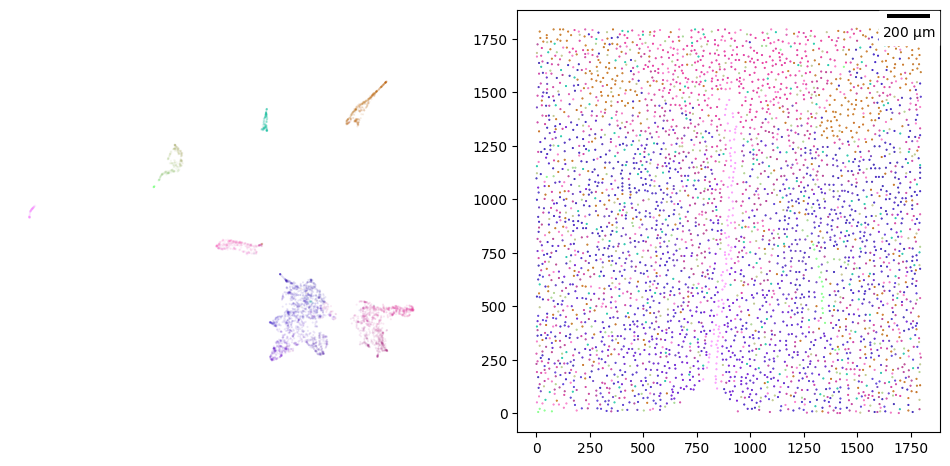

In [11]:
fig = ovrlpy.plot_pseudocells(dataset)

The signal integrity map can be visualized, where visualization is cut off at regions below a certain signal strength threshold:

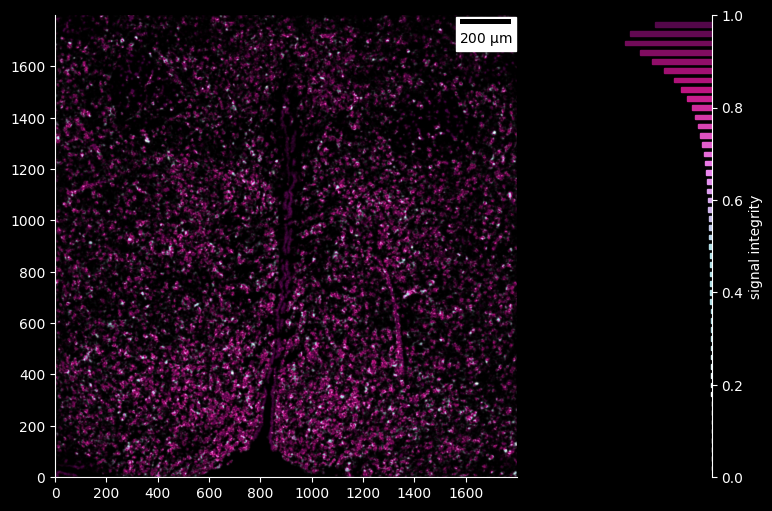

In [21]:
fig = ovrlpy.plot_signal_integrity(dataset, signal_threshold=3)

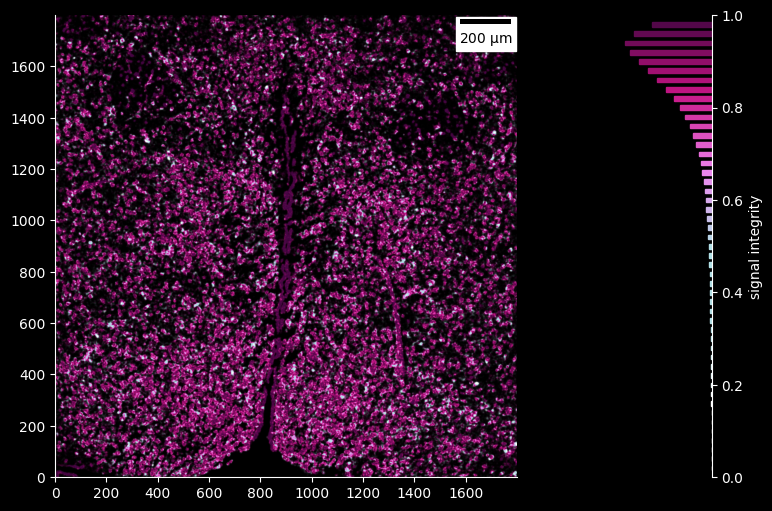

In [13]:
fig = ovrlpy.plot_signal_integrity(dataset, signal_threshold=2)

### Detecting doublets
We can detect individual doublet events with ovrlpy, again setting a signal strength threshold to filter out low-transcript regions:

In [9]:
doublets = dataset.detect_doublets(min_signal=3, # Minimum signal value for a peak to be considered
                                   integrity_sigma=1) # Optional sigma value for gaussian filtering of the integrity map, 
                                                      # which leads to the detection of overlap regions with larger spatial extent.

In [18]:
doublets.write_csv(result_folder / "doublets_df.csv")

And plot a multi-view visualization of the overlaps in the tissue:

In [10]:
window_size = 30

d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


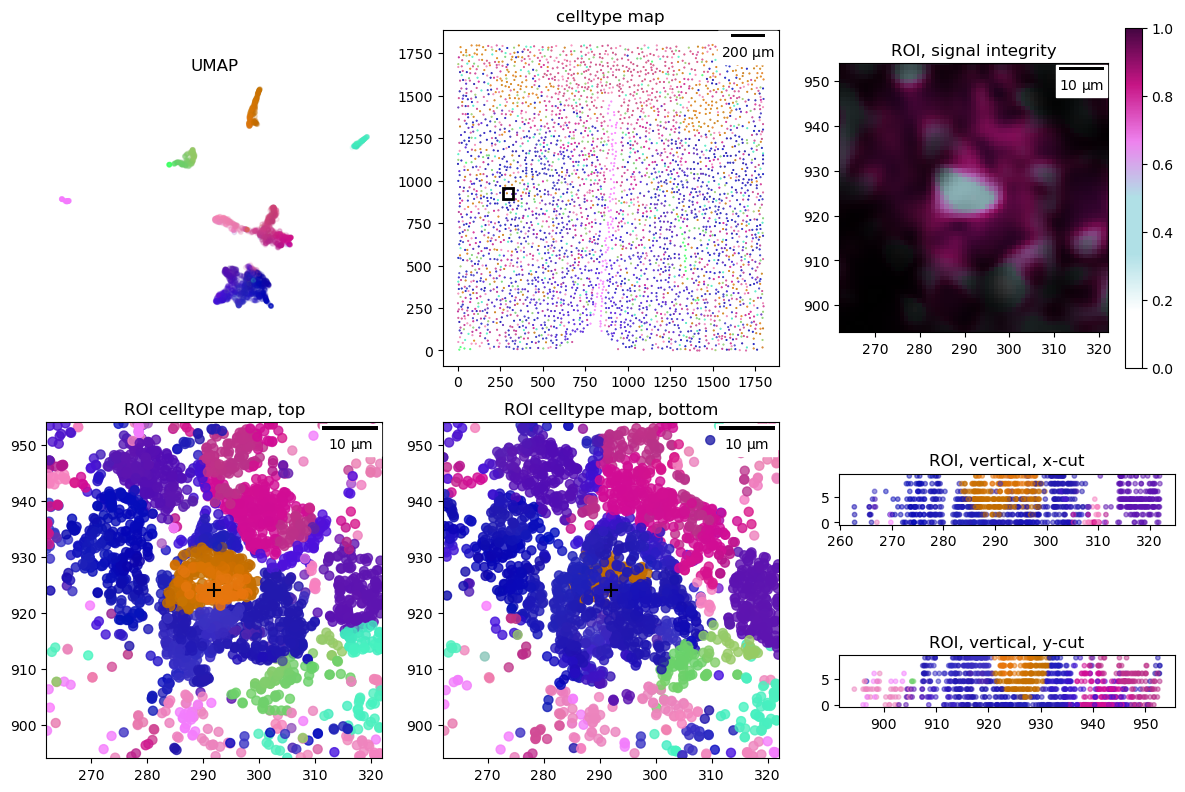

In [11]:
doublet_to_show = 49

x, y = doublets["x", "y"].row(doublet_to_show)

fig = ovrlpy.plot_region_of_interest(dataset, x, y, window_size=window_size)